# Importar librerias

In [1]:
import pyprojroot
import sys

package_path = pyprojroot.here().__str__()
if package_path not in sys.path:
    sys.path.append(package_path)

In [2]:
import re
import os
import pickle
import mlflow
import mlflow.sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import LoadData, AbsPaths

from sklearn.model_selection import train_test_split

# Loading and prepare data

In [3]:
final_data='operational_rdbms.csv'
df = LoadData().from_csv(file_name=final_data)
df.loc[:,'tourney_name']=df.tourney_name.str.upper() ###AGREGAR A CALIDAD DE DATOS.

In [4]:
df.head()

,tourney_date,tourney_name,surface,id,ht,wg,age,rank,minutes_played,pj,pg,pp,round
0,2000-01-17,AUSTRALIAN OPEN,Hard,101086.0,180.0,82.0,36,94.0,0.0,0.0,0.0,0.0,128
1,2000-01-17,AUSTRALIAN OPEN,Hard,101150.0,180.0,80.0,35,82.0,0.0,0.0,0.0,0.0,64
2,2000-01-17,AUSTRALIAN OPEN,Hard,101185.0,188.0,88.0,35,126.0,0.0,0.0,0.0,0.0,64
3,2000-01-17,AUSTRALIAN OPEN,Hard,101463.0,185.0,73.0,32,139.0,0.0,0.0,0.0,0.0,128
4,2000-01-17,AUSTRALIAN OPEN,Hard,101532.0,183.0,71.0,32,39.0,0.0,0.0,0.0,0.0,32


In [5]:
def one_hot_codification(data:pd.DataFrame, variable:str):

    new_variables= pd.get_dummies(data[variable], drop_first=True)
    data.loc[:,new_variables.columns]=new_variables
    data=data.drop(columns=variable)
    #data=pd.concat([data.drop(columns=variable),new_variables],axis=1)
    return data

In [6]:
def ordinal_codification(data:pd.DataFrame, variable:str):

    for i,j in enumerate(np.sort(df[variable].unique())):
        data.loc[data[variable]==j,variable+'_cod']=i
    
    data=data.drop(columns=variable)
    return data

In [7]:
def config_inputs(data, nominal_variables=None, ordinal_variables=None):
    if nominal_variables==None:
        nominal_variables=['surface', 'tourney_name']#,'id']
    if ordinal_variables==None:
        ordinal_variables=['round','tourney_date','id']
    for i in nominal_variables:
        data=one_hot_codification(data, i)
    for i in ordinal_variables:
        data=ordinal_codification(data,i)

    data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower().replace(' ', '_') for col in data.columns.str.lower()]
    return data

In [8]:
df2=config_inputs(df)

/tmp/ipykernel_273/3377404753.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_variables.columns]=new_variables
/tmp/ipykernel_273/3377404753.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_variables.columns]=new_variables


In [9]:
df2.head()

,ht,wg,age,rank,minutes_played,pj,pg,pp,grass,hard,roland_garros,us_open,wimbledon,round_cod,tourney_date_cod,id_cod
0,180.0,82.0,36,94.0,0.0,0.0,0.0,0.0,0,1,0,0,0,6.0,0.0,1.0
1,180.0,80.0,35,82.0,0.0,0.0,0.0,0.0,0,1,0,0,0,5.0,0.0,2.0
2,188.0,88.0,35,126.0,0.0,0.0,0.0,0.0,0,1,0,0,0,5.0,0.0,3.0
3,185.0,73.0,32,139.0,0.0,0.0,0.0,0.0,0,1,0,0,0,6.0,0.0,5.0
4,183.0,71.0,32,39.0,0.0,0.0,0.0,0.0,0,1,0,0,0,4.0,0.0,6.0


In [30]:
def make_train_test_split(x, y, test_size = 0.25, random_state = 42):

    (x_train, x_test, y_train, y_test) = train_test_split(
        x,
        y,
        test_size=test_size,
        random_state=random_state,
    )
    return x_train, x_test, y_train, y_test

In [19]:
AbsPaths().get_abs_path_folder(folder_name="reports")

'/workspace/reports/'

In [20]:
path_experiments = AbsPaths().get_abs_path_folder(folder_name="reports") + "figures/experiments_mlflow.png"

In [21]:
path_experiments

'/workspace/reports/figures/experiments_mlflow.png'

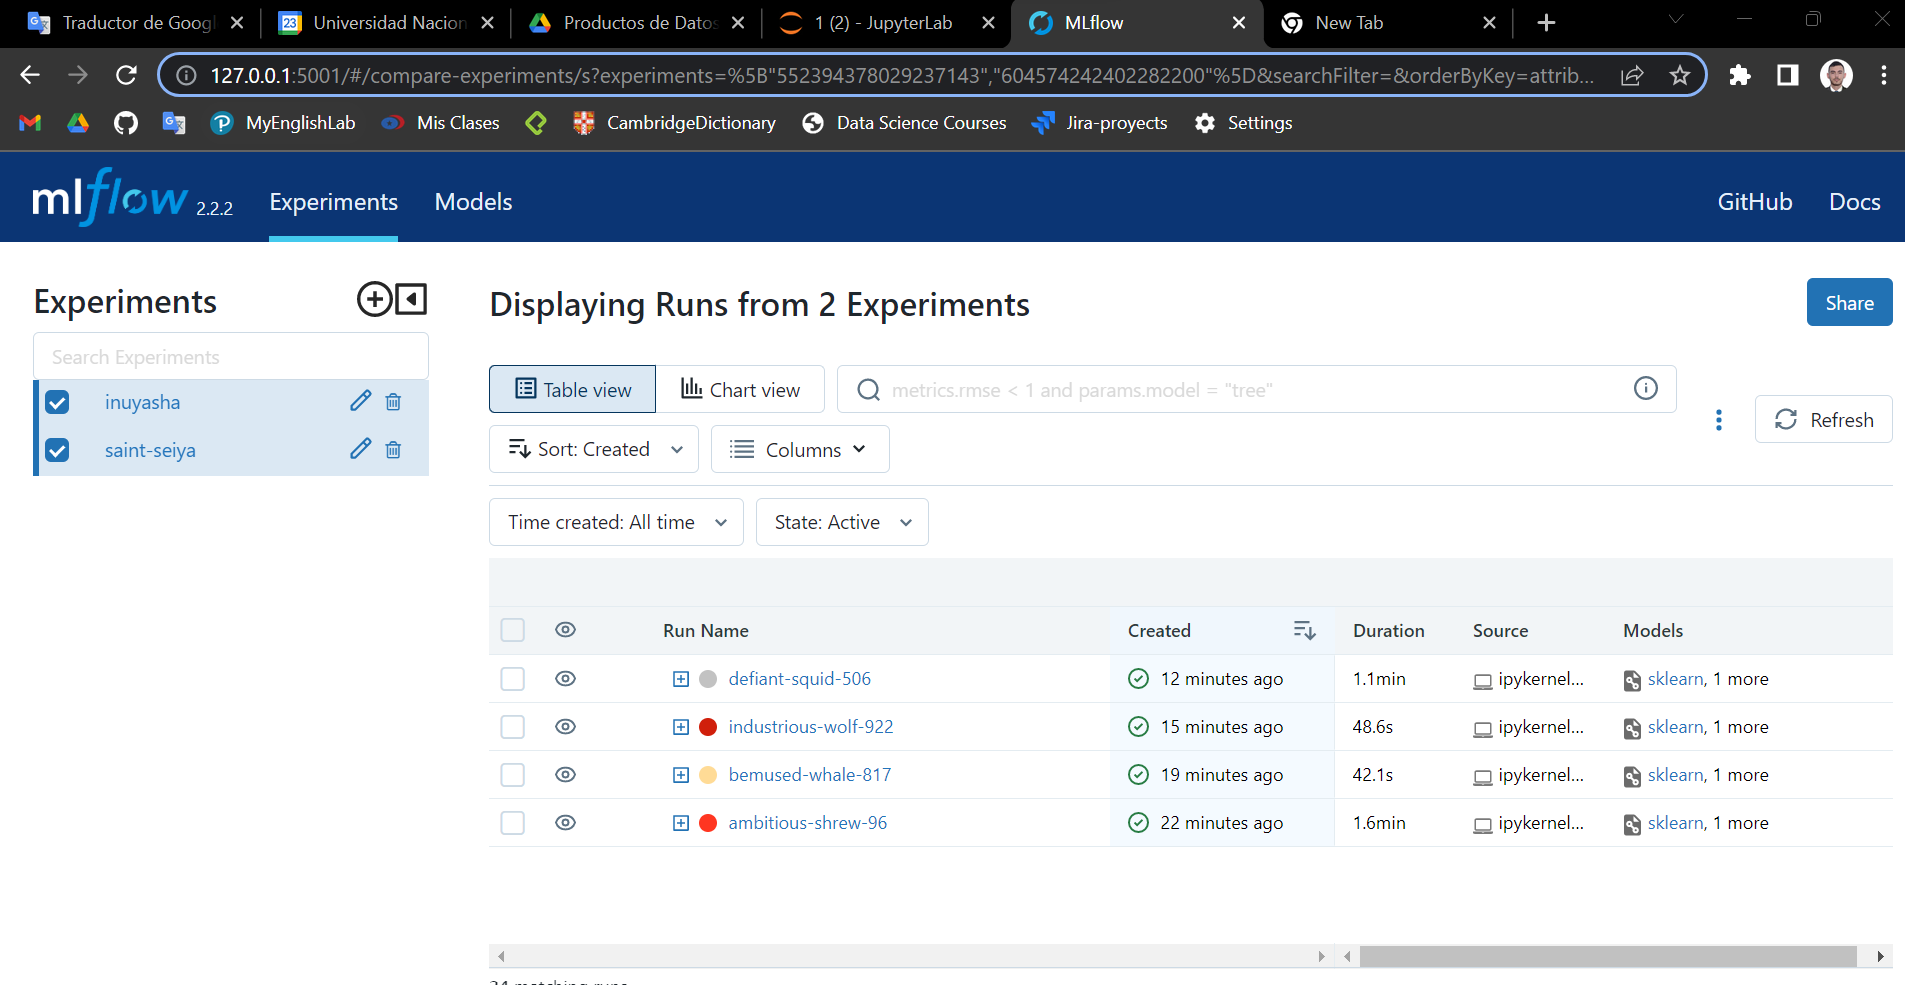

In [22]:
from IPython import display
display.Image(path_experiments)

In [31]:
def get_json_data(x, y):
    
    x_train, x_test, y_train, y_test = make_train_test_split(x=x, y=y)
    
    data = x_test.iloc[0:10, :].to_json(orient="split")
    
    data = '"dataframe_split": ' + data + ""
    data = "'" "{" + data + "}" + "'"
    
    return data
    

In [32]:
x=df2.drop(columns='round_cod')
y=df2.round_cod

In [33]:
data = get_json_data(x, y)

In [34]:
data

'\'{"dataframe_split": {"columns":["ht","wg","age","rank","minutes_played","pj","pg","pp","grass","hard","roland_garros","us_open","wimbledon","tourney_date_cod","id_cod"],"index":[8644,1076,2970,2029,8543,6231,2420,8109,4845,3884],"data":[[183.0,75.0,28,193.0,578.0,4.0,1.0,3.0,1,0,0,0,1,66.0,544.0],[180.0,75.0,26,41.0,736.0,6.0,4.0,2.0,0,1,0,0,0,8.0,139.0],[178.0,76.0,29,62.0,279.0,2.0,0.0,2.0,1,0,0,0,1,22.0,129.0],[180.0,75.0,22,146.0,0.0,0.0,0.0,0.0,1,0,0,0,1,14.0,339.0],[185.0,71.0,25,47.0,0.0,0.0,0.0,0.0,0,1,0,1,0,67.0,621.0],[188.0,83.0,25,89.0,0.0,0.0,0.0,0.0,0,1,0,0,0,48.0,512.0],[193.0,82.0,20,307.0,0.0,0.0,0.0,0.0,0,1,0,1,0,19.0,420.0],[193.0,80.0,29,49.0,1193.0,11.0,5.0,6.0,1,0,0,0,1,62.0,479.0],[190.0,84.0,22,3.0,653.0,4.0,2.0,2.0,0,0,1,0,0,37.0,514.0],[180.0,68.0,27,146.0,0.0,0.0,0.0,0.0,0,1,0,1,0,31.0,284.0]]}}\''

In [35]:
!curl http://127.0.0.1:5000/invocations -H 'Content-Type: application/json' -d {data}

{"predictions": [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 5.0, 5.0, 3.0, 6.0]}